#Virtual Patients

The idea is that the inducing inputs provided through sparse GP could be used to provide 'fake' data points, with all of the statistical and structural features of the original data.

###Inducing points, GP regression and Differential Privacy

Differential privacy works in the following way; given a function that generates a statistic (for example, in this case, an estimate of $y_*$ at $x_*$), we consider a dataset that generates that statistic (i.e. X,Y) with and without a single item (i.e. adding or removing a single training point). 

If we assume that the aim is to provide a prediction from a gaussian process we could assume the function is the prediction of $y_*$. We first need to find the maximum change in the estimate of $y_*$ by adding or removing that item. In standard Differential Privacy, it seems that the change that the removal of the item can cause is constrained. This is known as the sensitivity of the function (i.e. its $L_1$ norm). This isn't necessarily the correct logic: the output of our tool won't be a single prediction. We might be giving the ability of a user to perform prediction, by providing several matrices, etc. These will then be the 'outputs' of the 'function'. Alternatively we might just give the user a list of inducing points (in which case their values and locations will be the outputs). Either way, $y_*$ isn't the output we'll be providing, so I need to look at the maximum change in (say) $\Lambda$ due to adding or removing a datapoint, $x_i$? Maybe.

I'm a bit confused how to constrain the domain of the inputs, all the examples I saw in Dwork's work had domains with known, finite sets: Basically I need to read a little more: There's chapters in the DP book that might help (e.g. chapter entitled "When Worst-Case Sensitivity is Atypical"). I've still got half the book to read, so that might be top of my agenda, as it looks like there's going to be a lot of useful stuff in there.

Hall's work (referenced below) offers examples (including of Kernel Density Estimation) in which "if we use the gaussian kernel as the covariance function for the Gaussian process then upper bounding the RKHS norm of this function is trivial"... I don't yet understand this maths, but this might offer some help.

###Literature

I've not looked into the literature of Differential Privacy yet (beyond reading a few basic papers). I'll put them here when I do:

Hall, Rob, Alessandro Rinaldo, and Larry Wasserman. "Differential privacy for functions and functional data." The Journal of Machine Learning Research 14.1 (2013): 703-727.
http://www.stat.cmu.edu/~arinaldo/papers/hall13a.pdf
 - This looks really interesting, by adding a Gaussian Process to the function of interest, one can show that
 - "even if the data are not functions, we may want to release a data summary that is a function"
 
Hall, Rob. New Statistical Applications for Differential Privacy. Diss. University Park, 2013.
https://www.amstat.org/sections/bus_econ/papers/Rob_Hall.pdf
 - Rob Hall's PhD thesis is on "New Statistical Applications for Differential Privacy" with chapter 3: Differential Privacy in Spaces of Functions 
 
http://repository.cmu.edu/cgi/viewcontent.cgi?article=1065&context=jpc

https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf THE book on DP

##Introduction/example to sparse GP

We start with a modifed version of the GPSS example,

In [295]:
%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

k = GPy.kern.RBF(1)
N = 50
noise_var = 0.05
X = np.linspace(0,10,N)[:,None]
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)

Populating the interactive namespace from numpy and matplotlib


In [296]:
Z = np.hstack((np.linspace(2.5,4.,3),np.linspace(7,8.5,3)))[:,None]
m = GPy.models.SparseGPRegression(X,y,Z=Z)
m.likelihood.variance = noise_var
m.optimize()
#m.Z.fix()

{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7fb481e499d0>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7fb481ebd110>],
 'inducing_inputs': [<matplotlib.lines.Line2D at 0x7fb481ebd0d0>]}

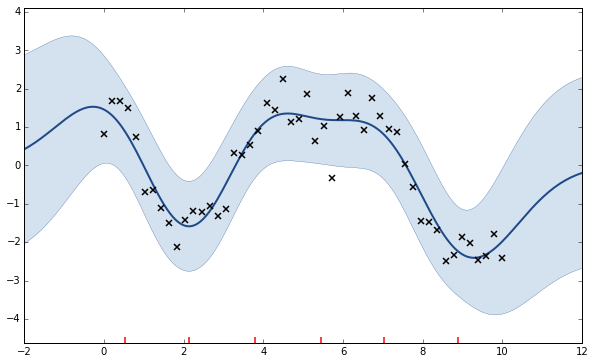

In [297]:
m.plot()

This plot offers an example of a sparseGP.

###Simple example with fewer points

To help me understand how sparseGP works, I've made an example with just a few data points (and only 3 inducing points).

I look at how easy it is to estimate the Xs given the outputs we will provided.

In [25]:
%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

N = 4
M = 3
noise_var = 0.1
X = np.linspace(0,10,N)[:,None]
#X = np.array([0.,5.,20.,25.,32.])[:,None]
y = np.hstack([np.linspace(1,2,np.floor(N/2.)),np.linspace(2,1,N-np.floor(N/2.))])
y = y[:,None]
y = y
print y
#y = (X.copy()*0.1)**2

Populating the interactive namespace from numpy and matplotlib
[[ 1.]
 [ 2.]
 [ 2.]
 [ 1.]]


In [26]:
k = GPy.kern.RBF(1,lengthscale=5.,variance=19.)
Z = np.linspace(0,10,M)[:,None]
m = GPy.models.SparseGPRegression(X,y,Z=Z)
m.likelihood.variance = noise_var
m.optimize()

{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f1e02d10150>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f1e02cf7810>],
 'inducing_inputs': [<matplotlib.lines.Line2D at 0x7f1e02cf77d0>]}

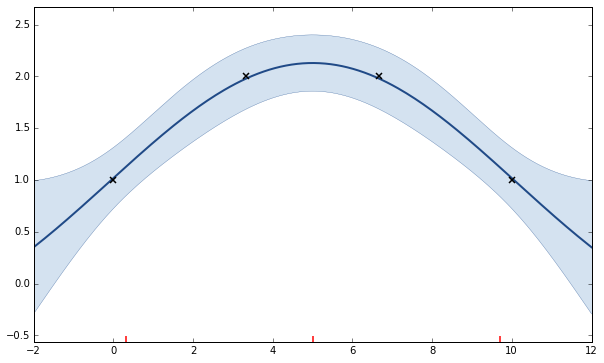

In [27]:
m.plot()

In [28]:
m.kern.K(m.Z, m.X)

array([[ 1.84774946,  1.64862501,  1.11146687,  0.56619626],
       [ 1.34975008,  1.78631287,  1.78631287,  1.34975008],
       [ 0.56619626,  1.11146687,  1.64862501,  1.84774946]])

In [29]:
m.Z

Index,sparse_gp.inducing_inputs,Constraint,Prior,Tied to
[0 0],0.310339500952,,,N/A
[1 0],5.0,,,N/A
[2 0],9.68966049905,,,N/A


In [30]:
m

sparse_gp.,Value,Constraint,Prior,Tied to
inducing inputs,"(3, 1)",,,
rbf.variance,1.84999496765,+ve,,
rbf.lengthscale,6.29677511968,+ve,,
Gaussian_noise.variance,0.0115045272197,+ve,,


###Estimating from the maths...

Can the user infer estimates or values of $X$ and $Y$ from:
$C$,
$\Lambda$,
$\Sigma^{-1}$ or
$Z$?

$C = \beta \Sigma^{-1} K_{UF} Y$

$\Sigma = K_{UU} + \beta K_{UF} K_{FU}$

The user has $\Sigma$ and can find $K_{UU}$ from Z and the kernel. So they have $\beta K_{UF} K_{FU}$.

What is $\beta$??? Assume it can be estimated for now?

So they have $K_{UF} K_{FU}$

In [31]:
np.dot(m.kern.K(m.Z, m.X),m.kern.K(m.Z, m.X).T)

array([[  7.68807932,   8.18861109,   5.75716185],
       [  8.18861109,  10.0254779 ,   8.18861109],
       [  5.75716185,   8.18861109,   7.68807932]])

If they can factorise this.. they'll have:

In [32]:
K_uf = m.kern.K(m.Z, m.X)
print K_uf

[[ 1.84774946  1.64862501  1.11146687  0.56619626]
 [ 1.34975008  1.78631287  1.78631287  1.34975008]
 [ 0.56619626  1.11146687  1.64862501  1.84774946]]


They'll be able to easily infer X, as they know Z and the kernel.

In [33]:
Z

array([[  0.],
       [  5.],
       [ 10.]])

In [34]:
m.rbf.lengthscale.values

array([ 6.29677512])

Example, distinguishing Z locations from $K_{UF}$ matrix.

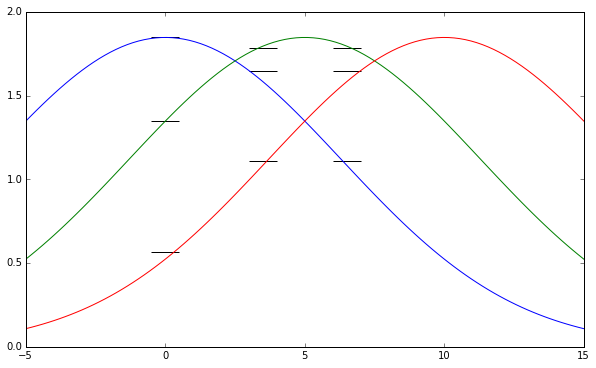

In [35]:
dom = np.linspace(-5,15,100)
plt.plot(dom,1.848*np.exp(-.5*(dom-Z[0])**2/m.rbf.lengthscale.values**2))
plt.plot(dom,1.848*np.exp(-.5*(dom-Z[1])**2/m.rbf.lengthscale.values**2))
plt.plot(dom,1.848*np.exp(-.5*(dom-Z[2])**2/m.rbf.lengthscale.values**2))
plt.hlines(K_uf[:,0],-.5,.5)
plt.hlines(K_uf[:,1],3,4)
plt.hlines(K_uf[:,2],6,7)

So the question is can the $K_{UF} K_{FU}$ matrix be inverted?

It is created by the product of a pair of matrices of the form:

    [      ] x [ ] = [ ]
               [ ]
               [ ] 
               [ ]
               
I.e. wide x long. Which gives a smaller matrix, and loses lots of info: E.g.

In [36]:
import numpy as np
U = np.array([0,1,2])
np.dot(U,U.T)

5

It seems like we can't recover that the original matrix was [0,1,2].

However, if we imagine a situation in which one of the inducing inputs was placed at the location of one of the data points, a long way from other data, then the matrix might look like:

In [37]:
U = np.array([[.2,.5,0],[0,0,1]])
print U

[[ 0.2  0.5  0. ]
 [ 0.   0.   1. ]]


In [38]:
np.dot(U,U.T)

array([[ 0.29,  0.  ],
       [ 0.  ,  1.  ]])

We know the locations of the inducing points and so, if we know the largest covariance value that can exist for that kernel (e.g. 1) then we know that one of the original data points was at the location of the second inducing point.

###Can we guess m.X?

Even though the earlier data and inducing points were mixed together, so that there were no zeros in the $K_{uf}$ matrix, it seems it's still possible to guess the locations of X from the $K_{uf} K_{fu}$ matrix and from the locations, $Z$, of the inducing points.

In [39]:
A = np.dot(m.kern.K(m.Z, m.X),m.kern.K(m.Z, m.X).T)

In [40]:
import numpy as np
from scipy.optimize import minimize

def cost(B):
    B = B[:,None]
    k = m.kern.K(m.Z, B)
    
    return np.sum((A - np.dot(k,k.T))**2) #sum sqr error

In [41]:
X0 = np.array([9,4,2,10]) #np.linspace(0,1,N)
print cost(X0)
res = minimize(cost, X0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
guesses = np.array(res.values()[4])[:,None]
print guesses
print X

5.35222239776
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 234
         Function evaluations: 410
[[  6.66666667e+00]
 [  4.47718170e-09]
 [  3.33333333e+00]
 [  1.00000000e+01]]
[[  0.        ]
 [  3.33333333]
 [  6.66666667]
 [ 10.        ]]


###How to handle this?

There are two problems this causes:

1. That we can estimate the values of X themselves.
2. That we can estimate the values of Y. This will still be uncertain as it'll have a CI surrounding it.

How to fix?

 - Move the values of the training data (add noise to X or Y)
 - Modify the $K_{uf}$ matrix (add noise there)
 - Move the positions of the inducing inputs after $K_{uf}$ is generated.
 
None of these seem ideal. I feel probably adding noise to the matrix might provide the most powerful method, but I'm not completely sure.

Populating the interactive namespace from numpy and matplotlib
[[  2.48591940e-008   9.94097688e-012   6.22846969e-022   2.26620845e-093
    3.26033275e-141   7.07594783e-240   2.04437884e-299]
 [  3.53105473e-056   4.61446197e-034   9.44817576e-019   1.19974864e-013
    1.34863861e-029   3.12584534e-077   2.95133727e-111]
 [  9.55178120e-200   4.15293142e-152   2.82901613e-111   1.32293663e-029
    1.18826028e-013   3.04853386e-010   9.57626489e-019]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 916
         Function evaluations: 1509
0.00
4.16
8.29
20.00
20.41
22.10
33.00
[[  0.]
 [  4.]
 [  8.]
 [ 20.]
 [ 25.]
 [ 33.]
 [ 37.]]
Note that some of the results were estimated, others were not. Those points nearest the inducing inputs were most vulnerable (makes sense?)
  Index  |  sparse_gp.inducing_inputs  |  Constraint  |   Prior   |  Tied to
  [0 0]  |               0.0026080189  |              |           |    N/A    
  [1 0]  |

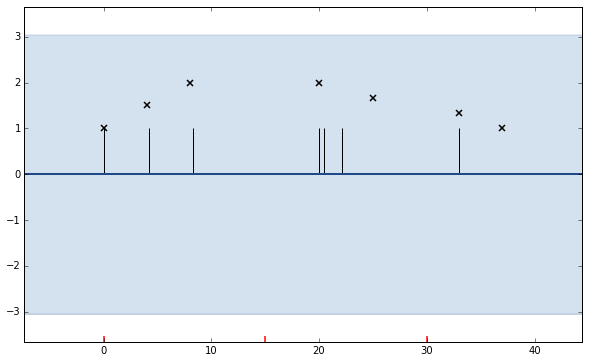

In [59]:
##Just another example, to illustrate that this can happen with more points.

%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

N = 7
M = 3
#noise_var = 0.1
X = np.array([0.,4.,8.,20.,25.,33.,37.])[:,None]
y = np.hstack([np.linspace(1,2,np.floor(N/2.)),np.linspace(2,1,N-np.floor(N/2.))])
y = y[:,None]
k = GPy.kern.RBF(1,lengthscale=5.,variance=19.)
Z = np.linspace(0,30,M)[:,None]
m = GPy.models.SparseGPRegression(X,y,Z=Z)
#m.likelihood.variance = noise_var
m.optimize()
print m.kern.K(m.Z, m.X)

A = np.dot(m.kern.K(m.Z, m.X),m.kern.K(m.Z, m.X).T)

import numpy as np
from scipy.optimize import minimize

def cost(B):
    B = B[:,None]
    k = m.kern.K(m.Z, B)
    
    return np.sum((A - np.dot(k,k.T))**2) #sum sqr error

X0 = np.linspace(0,30,N)
res = minimize(cost, X0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True, 'maxfev':10000})
guesses = np.array(res.values()[4])[:,None]
for g in guesses:
    print "%0.2f" % g
print X
print "Note that some of the results were estimated, others were not. Those points nearest the inducing inputs were most vulnerable (makes sense?)"
print m.Z
m.plot()
plt.vlines(guesses,0,1)

#Adding noise to the data

We can add noise to different parts of the system. We consider the most simple example, in which we perturb the inputs

$$\mathbf{\hat{x}} = \mathbf{x} + \mathbf{\epsilon}$$

To do this through the logic of DP, one needs to think about the sensitivity of the output. In this case the output is just the values of $\mathbf{\hat{x}}$.

So what is the sensitivity? As we are releasing all the values (i.e. all the rows of the database) we need to consider the local model.

###The Local Model

> So far we have considered a *centralized* model of data privacy...Instead, each individual maintains posession of their own data element (a database of size 1), and answers questions about it only in a differentially private manner.

> An $\epsilon$-local randomizer $R : \chi \rightarrow W$ is an $\epsilon$-differentially private algorithm that takes as input of size $n = 1$.

> -- page 238-9, The Algorithmic Foundations of Differential Privacy

The obvious down side is there is far more noise added to the data. For example, if one wanted to find the sum of 100 binary values, in a centralised database, one would need to add noise of $O(1)$. Specifically, for $\epsilon = 1$, the noise would be sampled from $\propto e^{-1}$. For the local model, each element of the database would have this noise added, with 100 elements the standard deviation of the total noise added (as each element's noise is iid) will be O(\sqrt{N}).

In [73]:
#A quick example to demonstrate: Finding the sum. First centralised data, with LaPlace noise added to the sum
import numpy as np
D = np.round(np.random.rand(100))
f = np.sum(D)
fhat = f+np.random.laplace(0,1) #centralised data
print("Centralised: Real value: %0.2f. With noise: %0.2f" % (f,fhat))
#if we want to release the database's whole content, we need to add noise to each element:
Dhat = D + np.random.laplace(0,1,size=(1,100))
ghat = np.sum(Dhat)
print("Local: With noise: %0.2f" % (ghat))
#if we want to release the database's whole content, we need to add noise to each element:

Centralised: Real value: 44.00. With noise: 43.56
Local: With noise: 52.21


This is the only option that we have open, without being able to prove that sparseGP provides DP.

We need to decide on other aspects now: What is the sensitivity? This will be the range of values that $\mathbf{x}$ can occupy. But this can be infinite. The book again has a section to cover this "When worst-case sensitivity is atypical". Different algorithms are suggested, including "Subsample and aggregate". This only works when $n>1$, which in the local model is not available. TO DO!

##Keeping the function reasonable

It seems we end up losing quite a bit by adding noise to the inputs. Especially if we keep the outputs equal to the same values. Should we change the outputs to preserve the original function a little?

We could sample the new output from the original GP.

Or we could pick a value for the output to make the new GP as close as possible to the original (including potentially adding more noise to the output value). This could be done using the 'standard' minimisation of the KL-divergence between the new function and the original.

Both these seem like good ideas, however one must be careful to preserve privacy, how do we ensure that we aren't providing clues; the original function contains information about the original data points, by using it to place y we are 'leaking' information from the original data.

#Differential Privacy and GPs

We are trying to produce a function (or functional) which describes the distribution of data in some private database D. We could use a Gaussian Process to model this data, however earlier notes suggest that, even using inducing points, we can't immediately remove knowledge of the data. However, we could add noise to the data or the function.

The paper "Differential Privacy for Functions" offers a method for adding noise to an arbitrary function $f$.

> Using the notation $K_x = K(x, . )$
>
> For two functions $f = \sum^n_{i=1} \theta_i K_{x_i}$ and $g = \sum^m_{j=1} \xi_j K_{y_j}$
> the inner product is given by:
>
> $$\left< f, g \right>_H = \sum_{i=1}^n \sum_{j=1}^m \theta_i \xi_j K(x_i, y_j)$$
>
> and the corresponding norm of $f$ is $||f||_H = \sqrt{ \left< f, f \right>_H }$

> For $f \in H$ where H is the RKHS corresponding to the kernel K, and for any finite sequence $x_1...x_n$ of distinct points in T, we have:

> matrix of $K(x_1, x_1) to K(x_n, x_n)$
> ..etc. Written easier as:
>
> $||K^{-1/2} f|| \leq ||f||_H$
>
> So the release of:
>
> $\hat{f_D} = f_D + {{\Delta c(\beta)} \over \alpha} G$
>
> is $(\alpha, \beta)$-DP whenever:
>
> $\Delta \geq sup_{D \sim D'} ||f_D - f_{D'}||_H$
>
> **When $G$ is the sample path of a Gaussian process having mean zero and covariance function K, given by the reproducing kernel of H.**

So supposing the function is the mean function of the GP. In the following I've added noise to $y$ as this might make things easier.

$$f_* | X, y, X_* \sim N(\bar{f_*}, cov(f_*) )$$

$f_* = K(X_*,X) K(X,X)^{-1} \mathbf{y}$

(note assumes no sample noise)

We follow the pattern in the paper, and consider two values of $\mathbf{y}$:

$f_*' - f_* = \left[K(X_*,X)^\top K(X,X)^{-1} \mathbf{y'}\right] - \left[K(X_*,X)^\top K(X,X)^{-1} \mathbf{y}\right]$

$f_*' - f_* = K(X_*,X)^\top K(X,X)^{-1} \left[\mathbf{y'} - \mathbf{y}\right]$

Where we define the two $y$ to be equal except for the last element, which differs by $s$.

So we can see that $\mathbf{s} = \left[\mathbf{y'} - \mathbf{y}\right] = [0,0,0,0,0,s]$. So the product $K(X,X)^{-1} \mathbf{s}$ is equal to the last column of the inverse of $K(X,X)$ multiplied by the constant $s$. If we make that column $\mathbf{a}$, then we can see that the result is:

$f_*' - f_* = \sum_{i=1}^n k_{*,x_i} a_i$

We need to put an upper bound on $f_*' - f_*$.

We can state that $k_{*,x_i} \leq 1$ [tbc], so that:

$f_*' - f_* \leq \sum_{i=1}^n a_i$

We need a constraint on the values in the final column of the $K(X,X)^{-1}$ matrix. I'm not sure what arbitrary constraints can be placed on this. One could however restrict the possible locations of the inputs.

##Moving the x values might be easier.

###Representer theorem

The mean of the posterior is expressed as:

$$\bar{f_*} = \mathbf{k_*^\top} K^{-1} \mathbf{y}$$

Which can be written as a summation,

$$\bar{f_*} = \sum_{i=1}^N \alpha_i k(\mathbf{x}_i, \mathbf{x})$$

where $\mathbf{\alpha} = K^{-1} \mathbf{y}$

####Simple example!

$X = [-.5,.5]$

$\mathbf{y} = [0,1]$

$\mathbf{x_*} = 0$

$K^{-1} \approx \left( \begin{array}{cc}
1.2 & -0.4 \\
-0.4 & 1.2 \\
\end{array} \right) $

So:

$\mathbf{\alpha} = K^{-1} \mathbf{y} = \left( \begin{array}{cc}
1.2 & -0.4 \\
-0.4 & 1.2 \\
\end{array} \right)
\left( \begin{array}{c}
0 \\
1 \\
\end{array} \right) = 
\left( \begin{array}{c}
-0.4 \\
1.2 \\
\end{array} \right)$

The kernel value at zero for both inputs is 0.78 (as they're equidistant).

We can then express the value of $\bar{f_*} = (-0.4 \times 0.78) + (1.2 \times 0.78) = 0.62$

(actual value without rounding errors: 0.5693)

Just to illustrate:

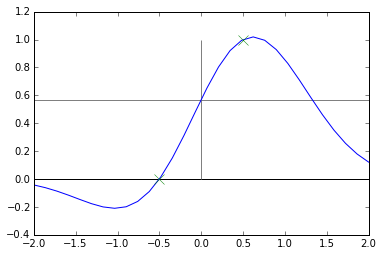

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.array([-.5,.5])
xstar = np.linspace(-2,2,30)
y = np.array([0,1])
def k(a,b): 
 #   print a.shape, b.shape
    a = a[:,None]
    b = b[:,None]
 #   print a.shape, b.shape
    a1 = a.repeat(b.shape[0],axis=1)
    b1 = b.repeat(a.shape[0],axis=1)
  #  print a1.shape, b1.shape
    return np.exp(-(a1.T-b1)**2)

#print k(x[1][None],xstar)
#print k(x,xstar)

K = k(x,x)
Kinv = np.linalg.inv(K)
alpha = np.dot((Kinv),y)

resarray = np.zeros_like(xstar)
for indx in range(len(xstar)):
    res = 0
    for i in range(len(alpha)):
        res += alpha[i] * k(x[i][None],xstar[indx][None])
    #print res
    resarray[indx] = res
plt.hlines(0,-2,2,color='black')
#plt.vlines(0,-1,1,color='grey')
plt.plot(xstar,resarray)
plt.plot(x,y,'x',markersize=10)
plt.vlines(0,0,1,color='grey')
plt.hlines(0.56934899,-2,2,color='grey')


#print resarray

How does this help us apply differential privacy?

Section 4.1 of Differential Privacy for Functions provides a method for adding gaussian process samples (as noise) to a function.

I've covered most of the important steps from the paper below, while leaving out the proofs.

We again consider two datasets, which differ in their last value, $n$.

We express our posterior estimate of the mean as:

$$f_D(x) = \sum_{i=1}^n a_i k(x,x_i)$$

where $n$ is the number of elements in $\mathbf{x}$, and $\mathbf{a} = K^{-1} \mathbf{y}$

###Detour to the paper

First I consider the solution in the paper and explain it in more detail, and then I'll look at why it isn't applicable here (at least without modification).

For the example in the paper (standard kernel density estimation), the function $f_D(x)$ is:

$$f_D(x) = C \sum_{i=1}^n k(x,x_i)$$

Where $C$ is a normalisation constant.

In the paper, the sensitivity $\Delta$ must be defined to be greater or equal to the distance between $f_D$ and $f_D'$, i.e. $\Delta \geq sup_{D \sim D'} ||f_D - f_D'||_H$.

We want to put an upper bound therefore on $||f_D - f_D'||$.

####The expression for $f_D(x) - f_D'(x)$

$$f_D(x) - f_D'(x) = C \sum_{i=1}^n k(x,x_i) - C \sum_{i=1}^n k(x,x'_i)$$

when $i \neq n$, $x'_i=x_i$ and the value in the sum of both $f_D$ and $f_D'$ are equal and cancel out. This leaves just the term in the summation when $i=n$.

$$f_D(x) - f_D'(x) = C k(x,x_n) - C k(x,x_n')$$

###Detour to RKHS

What is $||f_D - f_D'||$?

The norm of $g$ is defined to be:

$||g|| = \sqrt{\left< g,g \right>}$

Substituting in our expression:

$||f_D - f_D'||^2 = \left< C k(x,x_n) - C k(x,x_n'), C k(x,x_n) - C k(x,x_n') \right>$

We can use the linear property to 'factorise' the inner product:

$||f_D - f_D'||^2 = \left< C k(x,x_n), C k(x,x_n) \right> - \left< C k(x,x_n), C k(x,x_n') \right> - \left< C k(x,x_n'), C k(x,x_n) \right> + \left< C k(x,x_n'), C k(x,x_n') \right>$

Note that the symmetry property of inner products means the two middle terms are equal. The linear property means we can move the $C$ terms out of the inner products.

$||f_D - f_D'||^2 = C^2 \Big[ \left< k(x,x_n), k(x,x_n) \right> - 2 \left< k(x,x_n), k(x,x_n') \right>  + \left< k(x,x_n'), k(x,x_n') \right> \Big]$

We now use the magic of **Reproducing Kernel Hilbert Spaces**

We can consider the kernel $k(.,x_n)$ to be a functional, returning a different function, depending on the value of $x$. In particular we can write a kernel $k(x,x_n)$ (wrt this free variable $x$) as $k_{x_n}$. So $k_{x_n}(x) = k(x,x_n)$.

The RKHS property says that:

$\left< k_x, k_y \right>_H = k(x,y)$

So we can write $\left< k(x,x_n), k(x,x_n) \right>$ as:

$$\left< k(x,x_n), k(x,x_n) \right> = \left< k_{x_n}, k_{x_n} \right>$$

which we can write using properties of RKHS as:

$$\left< k_{x_n}, k_{x_n} \right> = k(x_n,x_n)$$

So using the same logic to the other terms in the earlier expression;

$$||f_D - f_D'||^2 = C^2 \Big[ k(x_n,x_n) - 2 k(x_n, x_n')  + k(x_n', x_n') \Big]$$

###Back to the paper...

The remaining parts of the paper are quite simple,

The expression $k(x_n,x_n) - 2 k(x_n, x_n')  + k(x_n', x_n')$ is upper bounded by 2 (as each kernel $\leq$ 1).

This means that $||f_D - f_D'||^2 \leq 2 C^2$

This allows us to pick a value for $\Delta = C \sqrt{2}$ which scales the sample drawn from the gaussian process.

###Back to our problem.

Can we apply this same logic to our own problem?

We noted that the mean of the GP can be expressed as follows:

$$f_D(x) = \sum_{i=1}^n a_i k(x,x_i)$$

where $\mathbf{a} = K^{-1} \mathbf{y}$

So following the logic of above,

$$f_D(x) - f_D'(x) = \sum_{i=1}^n a_i k(x,x_i) - \sum_{i=1}^n a'_i k(x,x'_i)$$

The immediate problem is that $a_i \neq a'_i$ (for $i \neq n$). So we can't cancel these elements.

If we left them in, what do we get?

$$f_D(x) - f_D'(x) = \sum_{i=1}^n a_i k(x,x_i) - a'_i k(x,x'_i)$$

$$||f_D(x) - f_D'(x)||^2 = \left< \sum_{i=1}^n a_i k(x,x_i) - a'_i k(x,x'_i), \sum_{i=1}^n a_i k(x,x_i) - a'_i k(x,x'_i) \right>$$

$$||f_D(x) - f_D'(x)||^2 = \sum_{i=1}^n \sum_{j=1}^n a_i a_j \left< k_{x_i}, k_{x_j}\right> - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j \left< k_{x_i}, k_{x'_j}\right> + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j \left< k_{x'_i}, k_{x'_j}\right>$$

$$||f_D(x) - f_D'(x)||^2 = \sum_{i=1}^n \sum_{j=1}^n a_i a_j k(x_i, x_j) - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j k(x_i, x'_j) + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j k(x'_i, x'_j)$$

We note that the kernels are all $\leq 1$, so:

$$||f_D(x) - f_D'(x)||^2 \leq \sum_{i=1}^n \sum_{j=1}^n a_i a_j - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j$$


$$||f_D(x) - f_D'(x)||^2 \leq \sum \mathbf{a} \mathbf{a^\top} - 2 \sum \mathbf{a} \mathbf{a'}^{\top} + \sum \mathbf{a'} \mathbf{a'}^\top$$

where these summations are over all elements in the matrix.

$$||f_D(x) - f_D'(x)||^2 \leq \mathbf{1} \mathbf{a} \mathbf{a^\top} \mathbf{1}^\top - 2 \mathbf{1} \mathbf{a} \mathbf{a'}^{\top} \mathbf{1}^\top + \mathbf{1} \mathbf{a'} \mathbf{a'}^\top \mathbf{1}^\top$$

**correction** The middle term's in the opposite direction, so we'll remove it.

$$||f_D(x) - f_D'(x)||^2 \leq \mathbf{1} \mathbf{a} \mathbf{a^\top} \mathbf{1}^\top + \mathbf{1} \mathbf{a'} \mathbf{a'}^\top \mathbf{1}^\top$$

Let $G = K^{-1}$

**wrong (assumes the middle term still exists)**

>We can write the above expression as: $(\mathbf{1 G y})(\mathbf{1 G y})^\top - (\mathbf{1 G y})(\mathbf{1 G' y})^\top + (\mathbf{1 G' y})(\mathbf{1 G' y})^\top$

>Where $\mathbf{1}$ is a row vector of ones.

>$|| . ||^2 \leq \Big[ (\mathbf{1 G y})-(\mathbf{1 G' y}) \Big] \Big[(\mathbf{1 G y})-(\mathbf{1 G' y}) \Big]^\top$

>$|| . || \leq (\mathbf{1 K^{-1} y})-(\mathbf{1 K'^{-1} y})$

>$\Delta \leq \mathbf{1 (G - G') y}$

**correction** As the middle term was missing above, we just write that:

$\Delta^2 \leq \mathbf{1 (a a^\top + a' a'^\top) 1^\top}$

substituting in for $\mathbf{a}$:

$\Delta^2 \leq \mathbf{1} \Big(G \mathbf{y} (G \mathbf{y})^\top + G' \mathbf{y} (G' \mathbf{y})^\top \Big) 1^\top$

$\Delta^2 \leq \mathbf{1} \Big(G \mathbf{y} \mathbf{y}^\top G^\top + G' \mathbf{y} \mathbf{y}^\top G'^\top \Big) 1^\top$

$\Delta^2 \leq \mathbf{1} (G + G') (\mathbf{y} \mathbf{y}^\top) (G + G')^\top 1^\top$

$\Delta^2 \leq \mathbf{1} (G + G') \mathbf{y} \mathbf{y}^\top (G + G')^\top 1^\top$

Note that $ \mathbf{1} (G + G') \mathbf{y}$ is scalar, and identical to the second half, leaving:

$\Delta^2 \leq \Big(\mathbf{1} (G + G') \mathbf{y} \Big)^2$

$\Delta \leq \mathbf{1} (G + G') \mathbf{y}$




Unfortunately this doesn't look any more generalisable. For a given pair of inverse covariance matrices, we have this bound on $\Delta$.

Could we use this still to select $\Delta$. One needs to be careful that the value of $\Delta$ doesn't releave information about the underlying data. A later section in the paper (4.1.2 Private Choice of Bandwidth) handles a similar problem in selecting a value of H. Could we apply a similar idea to the selection of $\Delta$. We need to find a differentially private version of $\hat{\Delta}$...

1 0.01
2 None
3 0.05
4 0.12
5 0.14
6 0.16
7 0.18
8 0.21
9 0.21
[-7.08416541  1.74712333  8.88976952]
25.1360004298
[[  1.00000000e+000   1.34478265e-034   1.52249145e-111]
 [  1.34478265e-034   1.00000000e+000   6.97311803e-023]
 [  1.52249145e-111   6.97311803e-023   1.00000000e+000]]
[[  1.00000000e+00  -1.34478265e-34   9.37732813e-57]
 [ -1.34478265e-34   1.00000000e+00  -6.97311803e-23]
 [  9.37732813e-57  -6.97311803e-23   1.00000000e+00]]
[-7.83316804 -8.37181314 -8.93101925]
--------------------
[-6.59899494 -1.13991503  5.99276501]
0.0928412948038
[[  1.00000000e+00   1.14116848e-13   1.38534992e-69]
 [  1.14116848e-13   1.00000000e+00   8.03922437e-23]
 [  1.38534992e-69   8.03922437e-23   1.00000000e+00]]
[[  1.00000000e+00  -1.14116848e-13   9.17410944e-36]
 [ -1.14116848e-13   1.00000000e+00  -8.03922437e-23]
 [  9.17410944e-36  -8.03922437e-23   1.00000000e+00]]
[ 2.12310834  2.56078064 -4.77673027]


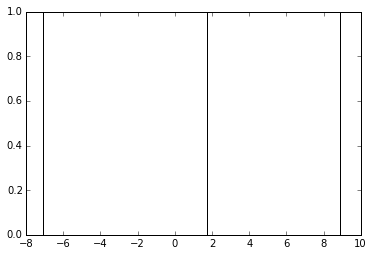

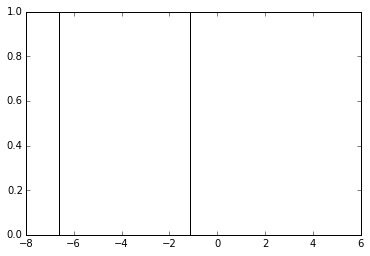

In [109]:
#What does K^-1 look like?


for ylim in range(1,10,1):
    thresh = None
    for ti in range(100):
        threshold = ti/100.0;
        minS = 1000000000
        minX = None
        minY = None
        maxS = -1
        maxX = None
        minY = None
        for i in range(500):
            while True:
                x = np.random.uniform(-10,10,size=3)
                x.sort()        
                if min(x[1:]-x[0:-1])>threshold:
                    break
            y = np.random.uniform(-ylim,ylim,size=3)
            s = np.abs( np.sum(np.dot(np.linalg.inv(k(x,x)),y)) )
            if s > maxS:
                maxS = s
                maxX = x
                maxY = y
            if s < minS:
                minS = s
                minX = x
                minY = y
        if maxS > 30:
            thresh = threshold
       #     print threshold
    print ylim, thresh
print maxX
print maxS
print k(maxX,maxX)
print np.linalg.inv(k(maxX,maxX))
print maxY
print "--------------------"
print minX
print minS
print k(minX,minX)
print np.linalg.inv(k(minX,minX))
print minY

plt.vlines(maxX,0,1)
plt.figure()
plt.vlines(minX,0,1)

#future idea: Fisher info puts a lower bound on variance (and so an upper bound on inverse variance) can we use that?%%!

In [68]:
x = np.array([1,3,6,1.2,2,5])


0.19999999999999996

The upshot is the upper bound on the sum of the elements in the inverse covariance matrix (for the rbf kernel) is $N$. To do: PROVE!

Not sure I can use that result, as we multiply it with $\mathbf{y}$. Other idea:

If $|\mathbf{y}| \leq y_{max}$ is bounded, and we also bound how close together the values of $\mathbf{x}$ can be. Then the upper bound on the $G \mathbf{y}$ result is equal to $N y_{max}$.

Substituting this in

$\Delta \leq 2 N y_{max}$

For example, $N = 10$, $y_{max}=10$ we also must ensure that $x$ is at least a certain distance apart:

$\Delta \leq 2 \times 10 \times 10 = 200$

An example:

In [274]:
%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

k = GPy.kern.RBF(1)
N = 10
noise_var = 0.001
X = np.linspace(0,10,N)[:,None]
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)
y = y+np.arange(-5.,5.,1.)[:,None]

Populating the interactive namespace from numpy and matplotlib


In [275]:
m = GPy.models.GPRegression(X,y)
#m.likelihood.variance = noise_var
m.optimize()

{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f9b81fbdc10>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f9b81faf310>],
  [<matplotlib.lines.Line2D at 0x7f9b81fbd150>]]}

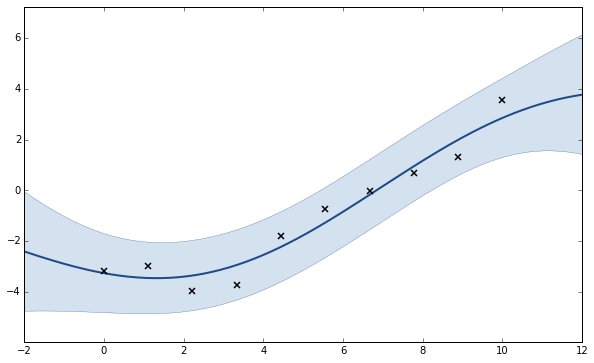

In [276]:
m.plot()

Below we try adding differential privacy to the mean function of the above GP.

This illustrates that, with the current bounds, the amount of noise added is very high (completely obscures the shape of the function) for a reasonable value of $\alpha$ (often called $\epsilon$). In the example below, instead of this value being of the order of 1, it's of the order of 100s. But hopefully illustrates the idea.

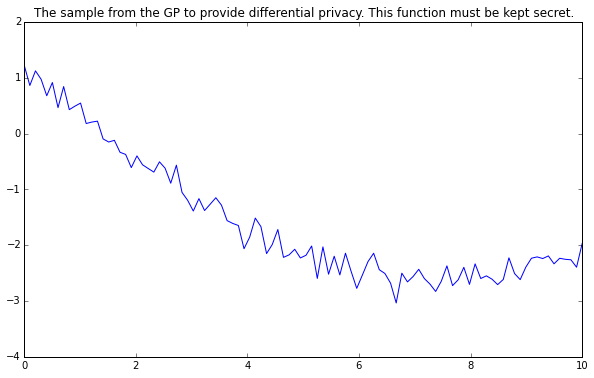

In [277]:
Nout = 100
x = np.linspace(0,10,Nout)
x = x[:,None]
G = np.random.multivariate_normal(np.zeros(Nout),m.kern.K(x)+np.eye(Nout)*np.sqrt(noise_var)).reshape(-1,1)
plot(x,G)
plt.title('The sample from the GP to provide differential privacy. This function must be kept secret.')

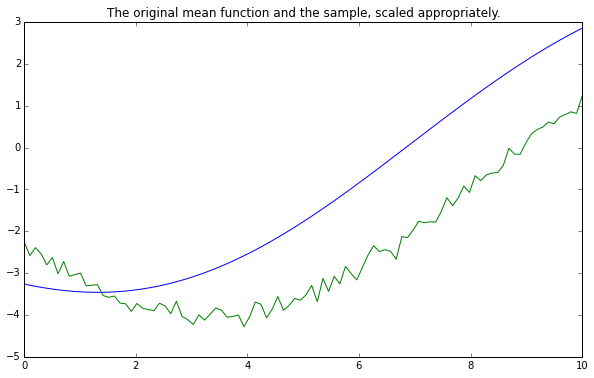

In [278]:

ypred = m.predict(x)[0]
plot(x,ypred)
delta = 2 * N * (max(ypred)-min(ypred)) ##!!!! NOT DIFFERENTIALLY PRIVATE ACCESS TO ymax!
alpha = 500.0 #! Very low privacy!
beta = 0.01
c = np.sqrt(2*np.log(2/beta)) #c > sqrt(2 log (2/beta)) e.g. beta = 0.1, c = sqrt(2 log (2/0.1)) = sqrt(2 log (20)) = 2.45
scale = delta * c / alpha
plot(x,ypred+G*scale)
plt.title('The original mean function and the sample, scaled appropriately.')

The upshot is that adding DP noise using the current bounds on the effect of $\mathbf{x_n}$ requires so much noise that the function's original shape is lost.

It might be that following the same logic but just for the outputs might preserve the function's shape.

#Emails and other stuff

> Hi!
> I learnt a lot and it was a good discussion today! Sorry I had to head
> off. I'm just installing GPy (with pip) at the moment (is that the best
> thing to do, or should I use the git repo?) - to try out what happens in
> more simple cases.
>
> I guess with the simple case (e.g. just two or three points and one or
> two inducing points) we should consider what information one might gain
> about the original data: I.e. maybe quantify the distribution of
> possible values a training point might take, or the joint distribution
> of what all training points might take, given the inducing points
> (that's what I was trying to get at when we were outside): So if you
> have the simple example of just two points and one inducing point, the
> joint distribution of those two points will probably be two bumps (on
> each side of the position of the inducing point). Not sure if that makes
> sense, but I'll mess about and see what I can come up with.
>
> This distribution maybe we could get from knowing where the inducing
> point would lie for such a simple case (and what variance would be
> expected at the inducing point, etc).
> Alternatively I could maybe work it out from the factorisation problem
> that you described; which is probably possible with the simple example
> and sufficiently restrictive priors? I don't know - will find out when I
> start trying stuff out.
>
> Once we've got some expression for the probability distribution of the
> original data, given the inducing points (even for this simple case) it
> might be possible to
> 1) see the change in entropy (for example) in the information known
> about the training points, and/or
> 2) see how it connects with differential privacy; i.e. how much noise we
> need to add - and link that to the K_{uf} matrix: I think that bit in
> particular is particularly novel and interesting: Up until now people
> can just add noise to the data points using Differential Privacy, and
> that would have worked, but this technique (of having a measure of how
> 'anonymous' a point is) hopefully adds it more 'efficiently'.
>
> Good stuff! I'll work on it tomorrow!
>
> Thanks!
>
> Btw: This is really perfect: It really links up a lot of questions and
> topics that I've been meaning to combine/work on, so it's unbelievably
> serendipitous! Neil will be very happy :D
>
> Mike.
>
> PS Just a thought, does it matter if, by chance, by adding noise to an
> inducing input location (say one that's on top of a training point, so
> it needs to move), it lands on a different training point. It's purely
> by chance, but is it obvious to an attacker that the inducing point is
> on a training point still - because of the new K_{uf} matrix? Or is it
> ok? ... So just wondering if adding noise to their locations isn't the
> right way to treat them, or something... I'll ponder this. Maybe it will
> need to be done repeatedly until the K_{uf} matrix has sufficiently
> small values... not sure. That doesn't seem like an ideal solution
> either. Or maybe careful selection of the noise to avoid such a
> collision. Doesn't feel very rigorous.


some information:

    m.Z are the inducing inputs
    m.X are the inputs

Thus

$K_{uf}$ is m.kern.K(m.Z, m.X)

The m.posterior holds the prediction information. See GP._raw_predict of how the prediction is being done. Important here is, that m._predictive_variable is m.Z in a SparseGP. 

From Felipe:


> Hi Max (cc Felix),
> 
> I am definitely interested in the topic and, in fact, briefly discussed about it with Karsten and Felix during my PhD committee meeting.
> 
> My immediate idea was based on the random-function approximation to Kernels. It is well-known that any kernel can be expressed as $k(x,x’) = \int_{\Omega}{\phi_{w}(x)\phi_{w}(x’)dP(w)}$, where $P(w)$ is a probabilistic measure. For many kernels, the functions $\phi_{w}(x)$ and the measure $P(w)$ are tractable and easy to compute. For example, one may approximate the RBF kernel with bandwidth $\sigma$ as follows:
> 
> To approximate $k(x,x’)=e^{-||x-x’||^{2}} / (2*\sigma^{2})$:
> 
> 1) Take N samples $b_{i}, i=1,\hdots,N$ from a Uniform distribution in $[0,2\pi]$
> 2) Take N samples $w_{i}, i=1’\hdots,N$ from a Normal distribution of mean $0$ and variance $\frac{1}{\sigma^{2}}$
> 3) Define $\phi_{w,b}(x)=\sqrt{2}\cos(w^{T}x + b)$ and $k_{i}(x,x’)=\phi_{w_{i},b_{i}}(x)\phi_{w_{i},b_{i}}(x’)$
> 4) The approximation to $k(x,x’)$ is given by the empirical mean of all $k_{i}(x,x’)$
> 
> Now, the reason why that could be useful is that we can compute kernel values without knowing the training points themselves. As long as we are given the values of $\phi_{w,b}(x)$ for a sufficiently large number of random pairs $(w,b)$, we can approximate the kernel. Also, computational complexity is greatly reduced thanks to separability.
> 
> Of course, a fundamental question would be: Can we recover the training points $x$ from the values of $\phi_{w,b}(x)$? If we can, privacy would be compromised. The mathematical answer is no, since the cosine function is not injective. However, it might be possible to learn some things about the training points (such as bounds and equivalence classes), which might still pose a problem for privacy. A key parameter in this sense would be the ratio $\frac{D}{N}$ (dimensionality of x versus number of approximating samples). However I think it might be a good starting point.

###To Discuss with Max

####Decision?
Do you want to allow the user:

- To create (anonymised) predictions (need $C$, $\Lambda$, $\Sigma^{-1}$ and $Z$).
- To just have the inducing points as the output (so just output Z and F(Z)?)

There are good reasons to have either.

The original plan (to just use the inducing points, and provide $\Sigma = K_{UU}+ K_{UF} K_{FU}$) can be shown to reveal private information, e.g. about the locations $X$, of the training data. We'll need to add noise to make this work (see above). 

I've not yet looked at where the noise needs to be added. Options:
 - Location of the inducing inputs ($Z$)
 - Values of the inducing inputs ($U$)
 - Modify matrices provided to the user
 - The original data (sort of defeats the cleverness of this method)

####How does this relate to Hall's work? 

His work (in particular the paper, Hall et al. 2013) focus on protecting the privacy of a function's values (I guess? I don't quite understand yet what "differential privacy for functions" means yet). While we're interested in protecting the privacy of the data that was used to create the function.

In [ ]:
.